# Trabajo práctico final
## Mellino, Natalia

In [40]:
## Imports
library(gtools)
library(RColorBrewer)
library(MASS)
library(kernlab) 
library(e1071)
library(caTools)
library(caret)

## Ejercicio 1



Elegimos un dataset para clasificación que usa estadísticas de la NBA para predecir si un jugador novato va a durar más de 5 años en la liga.

Las columnas son las siguientes:

![Columnas](dataset/tabla.png)

El dataset consta de 21 columnas y 1340 filas. La columna que queremos predecir es la columna "TARGET_5Yrs" que indica si el jugador duró más de 5 años en la liga o no.

### a) Información relevante al origen de los datos y su importancia

- [Origen de los datos](https://data.world/exercises/logistic-regression-exercise-1).


### b) Pre-tratamiento de los datos


In [57]:
## Hacemos un overview de nuestro dataset
nba <- read.csv("dataset/nba_logreg.csv")
head(nba)

,Name,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,⋯,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,⋯,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
2,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,⋯,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
3,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,⋯,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
4,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,⋯,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
5,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,⋯,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
6,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,⋯,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0


Vamos a tratar de identificar si hay **valores faltantes** en el dataset.

In [3]:
## Veamos si hay valores faltantes en nuestro dataset
na_count <-sapply(nba, function(y) sum(length(which(is.na(y)))))
data.frame(na_count)

,na_count
,<int>
Name,0
GP,0
MIN,0
PTS,0
FGM,0
FGA,0
FG.,0
X3P.Made,0
X3PA,0


Observamos que tenemos 11 valores faltantes todos en la columna `X3P`. Esto puede ser debido a que el jugador no haya realizado ningún intento de triple en su carrera. Por lo tanto, vamos a reemplazar estos valores por 0.


In [4]:
## Reemplazamos los valores NaN que observamos por 0.
nba[is.na(nba)] <- 0


Otra cosa que podemos hacer es remover la columna con el nombre de los jugadores ya que no nos sirve para el análisis y no aporta información relevante.

In [5]:
nba <- nba[,-1]

Nuestras variables son todas numéricas por lo que no es necesario realizar ningún tipo de transformación de variables categóricas, nominales, cíclicas, etc.

Lo que sí debemos hacer para concluir la preparación de los datos es **normalizar** las variables. Esto es necesario para que todas las variables tengan la misma escala y no haya variables que dominen el modelo.

In [6]:
## Normalizamos las variables de nuestro dataset
nba[, -20] <- scale(nba[, -20])

In [7]:
head(nba)

,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,FTM,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.4003780,1.1766268,0.13734969,-0.01728751,0.4771691,-1.5428313,0.6577959,1.2438896,0.3644670,0.306218922,0.36134949,-0.03784084,-0.3981409,1.01047510,0.5178034,0.2375509,-0.53325890,0.07322684,0.1472830,0
2,-1.4577372,1.1164436,0.09145229,-0.37367621,0.2267160,-2.3737643,1.1790534,1.9031180,0.2710199,1.319137598,1.19280303,0.58606736,-0.6555016,-0.01893098,-0.3083320,1.4610676,1.17506366,0.30630040,0.5624846,0
3,0.7792719,-0.2798071,-0.36752175,-0.37367621,-0.3298462,-0.3208710,0.3971671,0.8671876,0.3270881,-0.402824151,-0.39451737,-0.31198232,-0.6555016,-0.23951799,-0.4055244,-0.3742074,-0.28921282,-0.15984672,-0.2679187,0
4,-0.1384754,-0.7251629,-0.25277824,-0.19548186,-0.1072213,-0.2556998,-0.3847192,-0.2629183,0.2149516,-0.402824151,-0.39451737,-0.13237238,-0.0120998,-0.82775004,-0.5513130,-0.5101537,-0.04516674,-0.62599384,-0.2679187,1
5,-0.7120675,-0.7371995,-0.52816266,-0.61126868,-0.8029241,1.3409951,-0.6453479,-0.6396203,-1.1929849,0.002343319,0.05900274,-0.27416970,-0.0120998,-0.38657600,-0.2597358,-0.8500194,-0.77730498,0.07322684,-0.5447197,1
6,0.8366311,-0.7492362,-0.71175228,-0.67066679,-0.6637835,-0.3045782,0.1365384,0.3021347,0.8317025,-0.909283489,-0.99921086,0.27411326,-1.0415427,-0.97480805,-1.0858712,0.1695778,-0.53325890,-0.85906740,-0.6831203,0


### c) Análisis de los datos

Observemos que tenemos muchas columnas. Es necesario hacer un análisis gráfico de los datos para ver si podemos identificar a simple vista variables importantes (o no importantes) y como están distribuidas las clases para ver si hay desbalance.


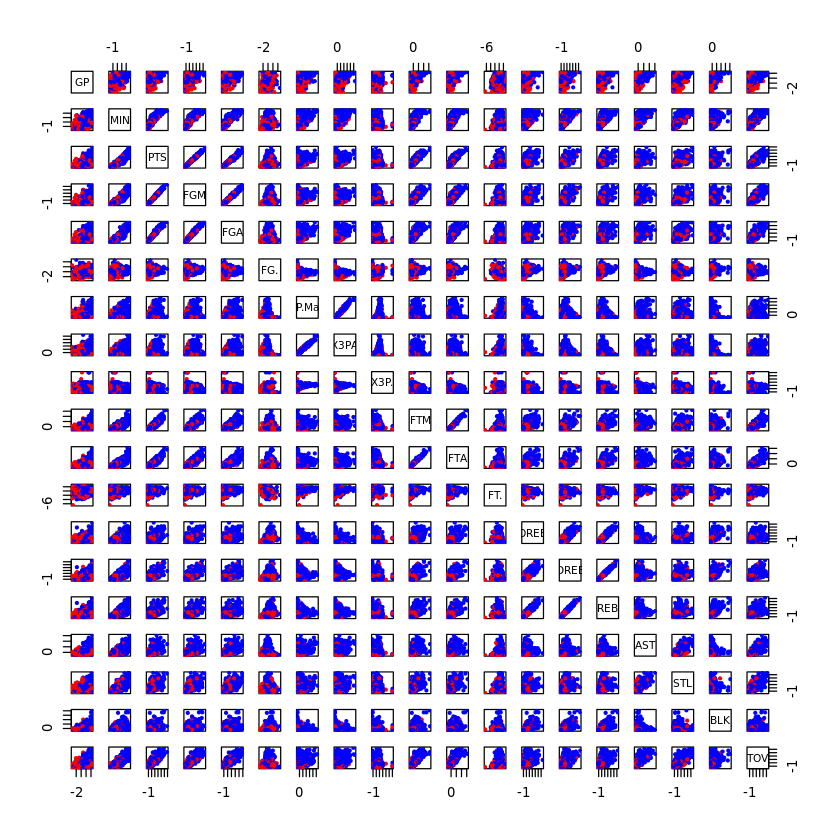

In [8]:
## Hacemos un plot de las variables comparándolas 1 a 1
nba.pairs.plot <- pairs(nba[, -20], pch = 19, cex = 0.5, col=c("red", "blue")[nba$TARGET_5Yrs+1])

Como se ve muy pequeña la imagen, guardamos este plot aparte y se puede visualizar mejor en `dataset/output.png`. Podemos ver un par de variables con una gran correlación. Vamos a graficarlas para observarlas en más detalle.


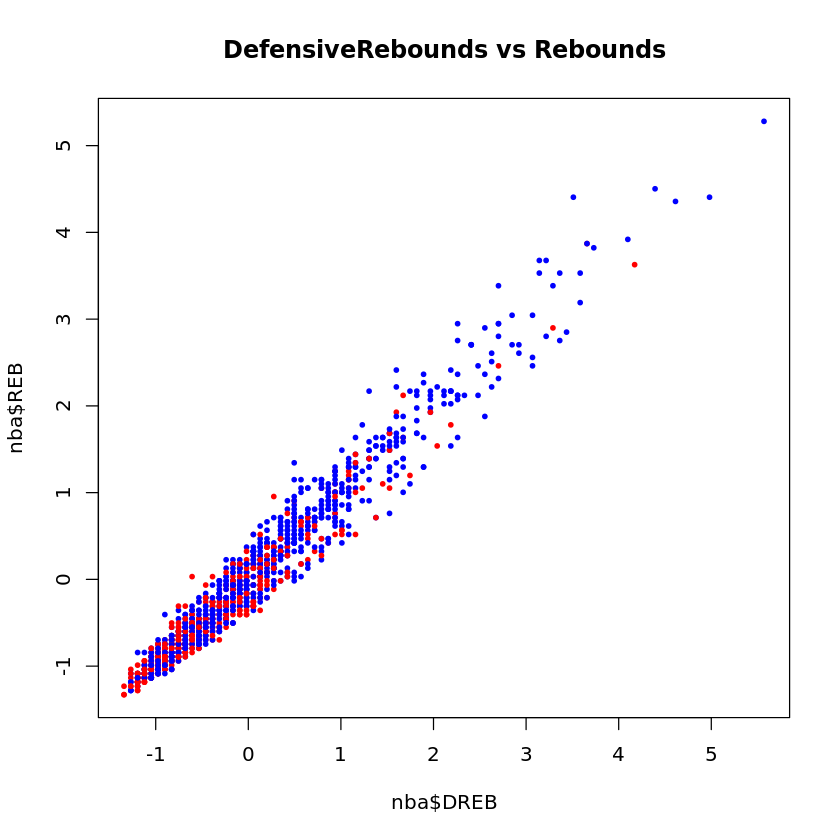

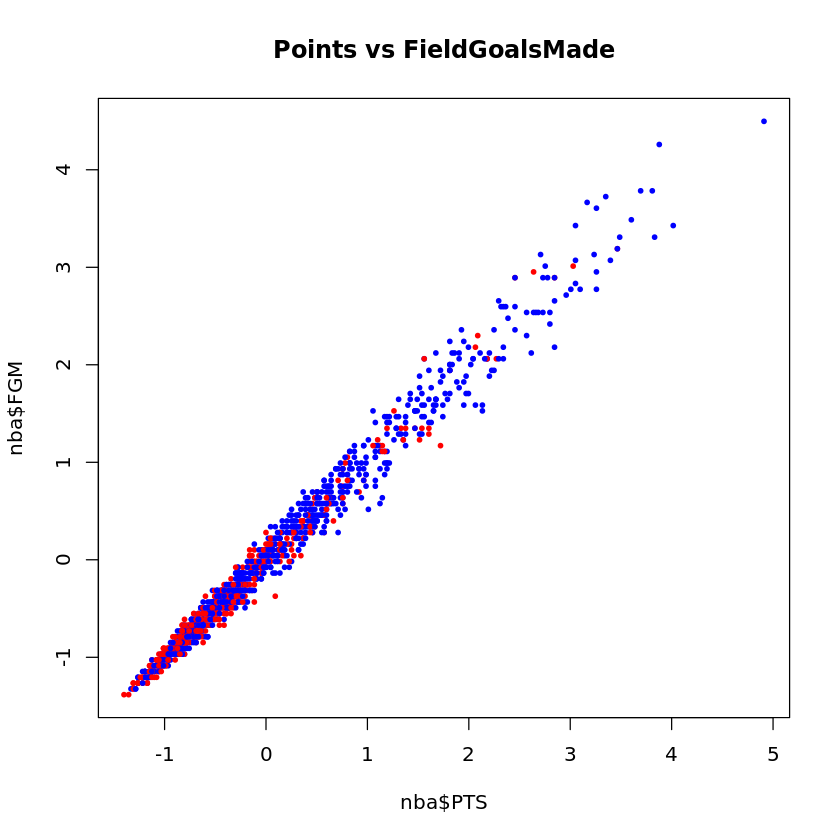

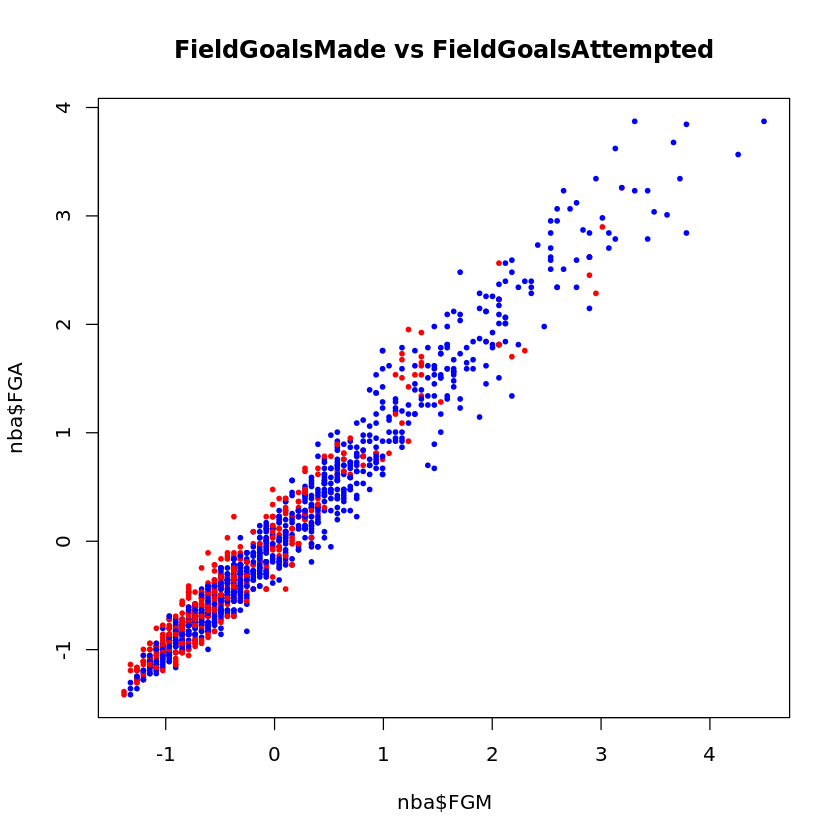

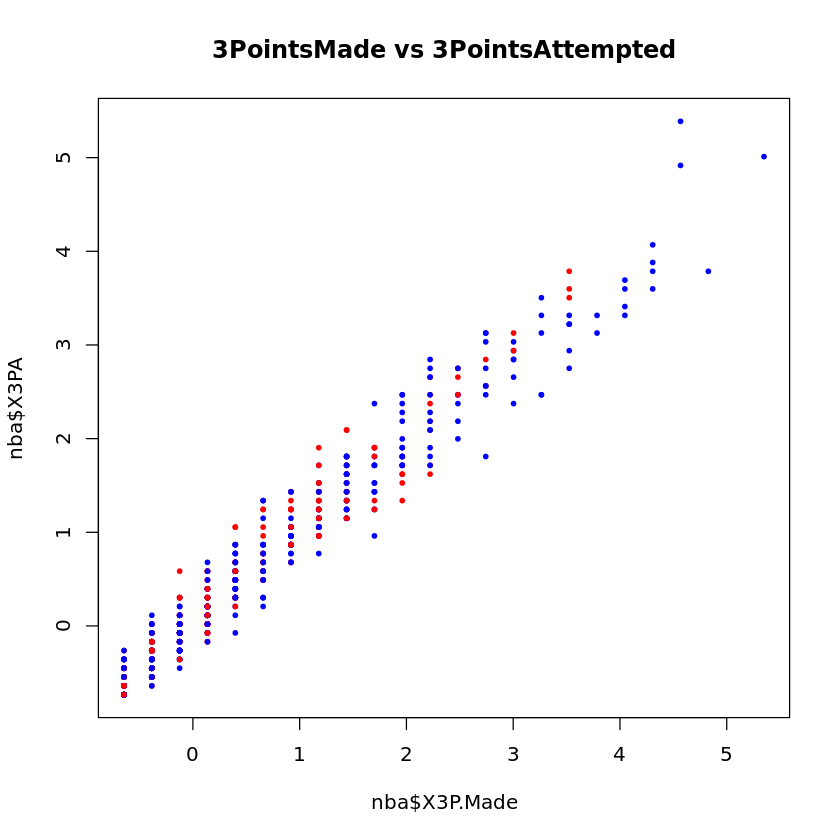

In [9]:
# Graficamos DREB y REB
plot(nba$DREB, nba$REB, pch = 19, cex = 0.5, col=c("red", "blue")[nba$TARGET_5Yrs+1], main="DefensiveRebounds vs Rebounds")
# Graficamos PTS y FGM
plot(nba$PTS, nba$FGM, pch = 19, cex = 0.5, col=c("red", "blue")[nba$TARGET_5Yrs+1], main="Points vs FieldGoalsMade")
# Graficamos FGM y FGA
plot(nba$FGM, nba$FGA, pch = 19, cex = 0.5, col=c("red", "blue")[nba$TARGET_5Yrs+1], main="FieldGoalsMade vs FieldGoalsAttempted")
# Graficamos X3Made y X3PA
plot(nba$X3P.Made, nba$X3PA, pch = 19, cex = 0.5, col=c("red", "blue")[nba$TARGET_5Yrs+1], main="3PointsMade vs 3PointsAttempted")


Claramente hay una alta correlación entre estas variables viendolas en este gráfico. Nos resta analizar si es necesaria esta correlación para el modelo, tal vez si una variable es transformación de la otra podemos obviar algunas y quitarlas de nuestro modelo para simplificarlo. A simple vista y teniendo una noción de lo que representan cada variable tiene todo el sentido que estén correlacionadas. **TODO: COMPLETAR**

## Ejercicio 2

Análisis de variables relevantes. Observemos que tenemos muchas variables. Como vimos en la teoría, podemos intentar usar primero un método de filtro y luego uno de *wrapper* para hilar más fino. Vamos a usar el método de filtro para ver si podemos identificar variables que no aporten información relevante.

In [10]:
## Para método de filtro usamos Kruskal-Wallis
kruskal.ranking <- function(x, y){
    
    size <- dim(x)[2]
    ranking <- c()
    for(i in 1 : size){
        feature <- x[, i]
        value <- kruskal.test(feature, y)$statistic
        ranking[i] <- value 
    }

    # Preparamos la info
    ranking <- sort(ranking, decreasing=TRUE, index=T)$ix
	
    search.names = colnames(x)[ranking]

	imp = (size : 1) / size
	names(imp) = search.names
	
    
 	
    return(list(ordered.names.list = search.names, 
 	            ordered.features.list = ranking, 
 	            imp = imp))

    
}

ordernar_nombres <- function(names, values){
    indexes <- mixedorder(names)
    sorted.values <- 1:length(indexes)
    iterator <- 1
    for(i in indexes){
        sorted.values[iterator] <- values[i]
        iterator <- iterator + 1
    }

    return(list(ordered.names=mixedsort(names), ordered.values=sorted.values))
}

# Funcion para graficar la importancia de las variables
graficar_valores <- function(datos, titulo="Plot"){
    datos_ordenados <- ordernar_nombres(datos$ordered.names.list, unname(datos$imp))
    names <- datos_ordenados$ordered.names
    importance <- datos_ordenados$ordered.values
    coul <- brewer.pal(5, "Set2")
    barplot(height=importance, names=names, col=coul, main=titulo, las=2)
}


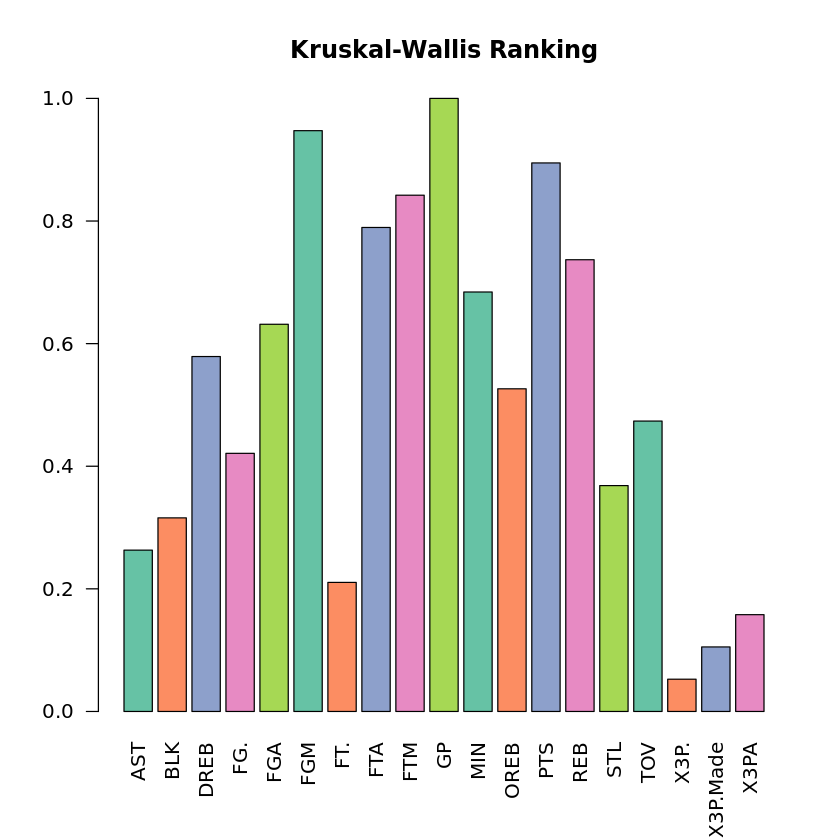

In [11]:
nba.kruskal <- kruskal.ranking(nba[, -20], nba$TARGET_5Yrs)
graficar_valores(nba.kruskal, "Kruskal-Wallis Ranking")

Vemos que las variables menos relevantes son las relacionadas a los tiros 'triples'. Tiene sentido supongo ya que no son muy frecuentes. Una variable que seguro podemos sacar es la de porcentajes ya que puede ser engañosa: si un jugador tiene un porcentaje de tiros triples muy alto puede pasar que tal vez sólo intento una vez y lo acertó, eso no es tan bueno como uno que tiene un porcentaje bajo pero los intenta más veces. Por lo tanto, vamos a sacar las variables de porcentajes: `X3P.`, `FG.`, `FT.`. Luego sacamos aquellas que tuvieron un ranking demasiado bajo: `X3PA`, `X3P.Made`, `AST`, y `BLK`.

In [12]:
## Sacamos del dataset las variables X3P., FG., FT., X3PA, X3P.Made, AST, y BLK.
nba<-nba[, -c(6, 7, 8, 9, 12, 16, 18)]
head(nba)

,GP,MIN,PTS,FGM,FGA,FTM,FTA,OREB,DREB,REB,STL,TOV,TARGET_5Yrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.4003780,1.1766268,0.13734969,-0.01728751,0.4771691,0.306218922,0.36134949,-0.3981409,1.01047510,0.5178034,-0.53325890,0.1472830,0
2,-1.4577372,1.1164436,0.09145229,-0.37367621,0.2267160,1.319137598,1.19280303,-0.6555016,-0.01893098,-0.3083320,1.17506366,0.5624846,0
3,0.7792719,-0.2798071,-0.36752175,-0.37367621,-0.3298462,-0.402824151,-0.39451737,-0.6555016,-0.23951799,-0.4055244,-0.28921282,-0.2679187,0
4,-0.1384754,-0.7251629,-0.25277824,-0.19548186,-0.1072213,-0.402824151,-0.39451737,-0.0120998,-0.82775004,-0.5513130,-0.04516674,-0.2679187,1
5,-0.7120675,-0.7371995,-0.52816266,-0.61126868,-0.8029241,0.002343319,0.05900274,-0.0120998,-0.38657600,-0.2597358,-0.77730498,-0.5447197,1
6,0.8366311,-0.7492362,-0.71175228,-0.67066679,-0.6637835,-0.909283489,-0.99921086,-1.0415427,-0.97480805,-1.0858712,-0.53325890,-0.6831203,0


Logramos reducir nuestro número de variables de 21 a 13. Vamos a ver si podemos mejorar esto con un método de *wrapper*.

In [13]:
## Usamos backward ranking con svm

svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}

backward.ranking <- function(x, y, method, ...){

    max.feat = dim(x)[2]
	list.feat = 1 : max.feat
	keep.feat = double(max.feat)
	  
	# Iteraremos hasta que eliminemos todos los features menos 1

	while(length(list.feat) > 1){
		class.error = double(length(list.feat))
		# Entrenamos y medimos el error para cada modelo sacando de a una feature a la vez
		for(i in 1 : length(list.feat)){
			x.train = as.matrix(x[, list.feat[-i]])
			class.error[i] = do.call(method, c(list(x.train, y), list(...)))
		}
		
		# Eliminamos el feature que nos da menos error al sacarlo (es el menos importante)
		min.index = which.min(class.error)
		keep.feat[length(list.feat)] = list.feat[min.index]
		list.feat = list.feat[- min.index]
	}
	
	# El último feature en eliminar es el que haya quedado de las iteraciones anteriores.
	keep.feat[1] = list.feat[1]
	
	# Preparamos la info
	search.names = colnames(x)[keep.feat]
	imp = (max.feat : 1) / max.feat
	names(imp) = search.names
	
 	return(list(ordered.names.list = search.names, 
 	            ordered.features.list = keep.feat, 
 	            imp = imp))

}

In [ ]:
nba.backward <- backward.ranking(nba[, -13], nba$TARGET_5Yrs, method="svm.est")

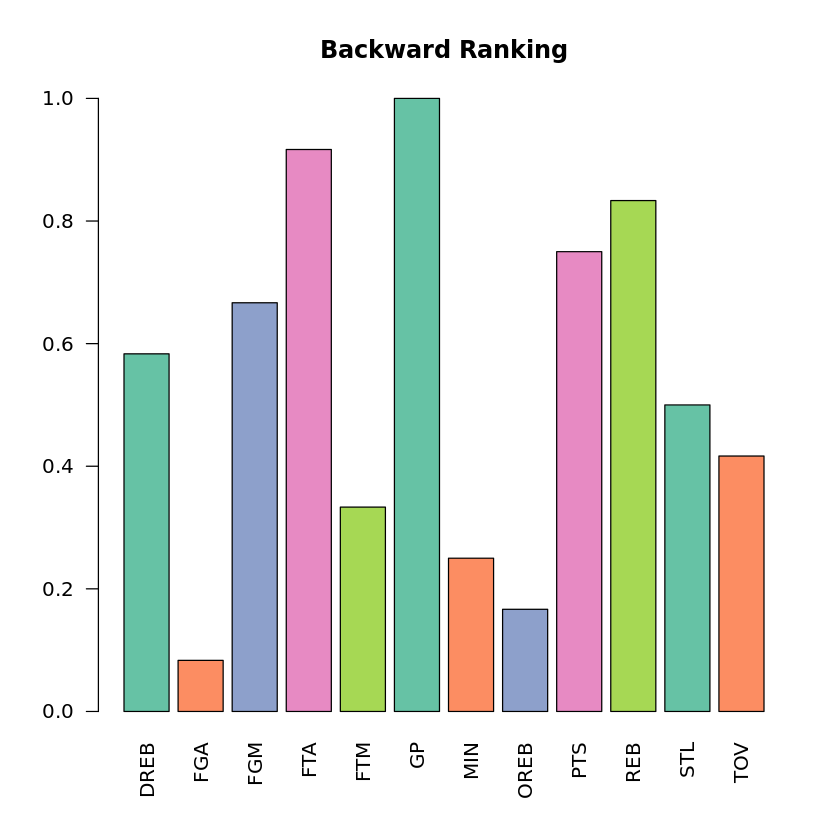

In [15]:
graficar_valores(nba.backward, "Backward Ranking")

En esta corrida podemos ver que la variable `MIN` (Minutes Played) es mucho menos importante que en Kruskal, podemos probar prescindir de ella ya que tenemos la variable `GP` (Games Played) la cual puede funcionar como un estimativo de los minutos jugados. Vamos a probar sacarla y ver que pasa.

Por otro lado, `FGA` (Field Goal Attemps) ahora ya no tiene tanta importancia como `FGM` (Field Goals Made). Ya que tiene un valor muy bajo, vamos a probar sacarla también.

In [16]:
## Sacamos la variable FGA y MIN
nba<-nba[, -c(2, 5)]
head(nba)

,GP,PTS,FGM,FTM,FTA,OREB,DREB,REB,STL,TOV,TARGET_5Yrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.4003780,0.13734969,-0.01728751,0.306218922,0.36134949,-0.3981409,1.01047510,0.5178034,-0.53325890,0.1472830,0
2,-1.4577372,0.09145229,-0.37367621,1.319137598,1.19280303,-0.6555016,-0.01893098,-0.3083320,1.17506366,0.5624846,0
3,0.7792719,-0.36752175,-0.37367621,-0.402824151,-0.39451737,-0.6555016,-0.23951799,-0.4055244,-0.28921282,-0.2679187,0
4,-0.1384754,-0.25277824,-0.19548186,-0.402824151,-0.39451737,-0.0120998,-0.82775004,-0.5513130,-0.04516674,-0.2679187,1
5,-0.7120675,-0.52816266,-0.61126868,0.002343319,0.05900274,-0.0120998,-0.38657600,-0.2597358,-0.77730498,-0.5447197,1
6,0.8366311,-0.71175228,-0.67066679,-0.909283489,-0.99921086,-1.0415427,-0.97480805,-1.0858712,-0.53325890,-0.6831203,0


In [17]:
## Guardamos el dataset transformado hasta acá para no tener que correr todo de vuelta cada vez que abrimos el notebook
write.csv(nba, "nba_transformado.csv")

## Ejercicio 3: búsqueda de clusters

In [3]:
## Cargamos el dataset transformado que guardamos anteriormente
nba.transformado <- read.csv("nba_transformado.csv", header = TRUE, sep = ",")
## Sacamos la primer columna que son los índices
nba.transformado <- nba.transformado[, -1]
head(nba.transformado)

,GP,PTS,FGM,FTM,FTA,OREB,DREB,REB,STL,TOV,TARGET_5Yrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,-1.4003780,0.13734969,-0.01728751,0.306218922,0.36134949,-0.3981409,1.01047510,0.5178034,-0.53325890,0.1472830,0
2,-1.4577372,0.09145229,-0.37367621,1.319137598,1.19280303,-0.6555016,-0.01893098,-0.3083320,1.17506366,0.5624846,0
3,0.7792719,-0.36752175,-0.37367621,-0.402824151,-0.39451737,-0.6555016,-0.23951799,-0.4055244,-0.28921282,-0.2679187,0
4,-0.1384754,-0.25277824,-0.19548186,-0.402824151,-0.39451737,-0.0120998,-0.82775004,-0.5513130,-0.04516674,-0.2679187,1
5,-0.7120675,-0.52816266,-0.61126868,0.002343319,0.05900274,-0.0120998,-0.38657600,-0.2597358,-0.77730498,-0.5447197,1
6,0.8366311,-0.71175228,-0.67066679,-0.909283489,-0.99921086,-1.0415427,-0.97480805,-1.0858712,-0.53325890,-0.6831203,0


Ya que no estamos en presencia de 'jerarquías' vamos a probar con cluster divisivo, vamos a usar K-Means buscando primero el número óptimo clusters con gap_statistics.

### Código de tp anteriores

In [15]:
check.cluster <- function(cc, original){
  cont.table <- table(original,cc$cluster)
  class.match <- matchClasses(as.matrix(cont.table),method="exact")
  print(cont.table[,class.match])
  print(cont.table)
}

In [20]:
# Calcula el Gap(k) para el algoritmo gap_statistic
gap <- function(k, B, wkb.vector, Wk) {
    acumulador <- 0 
    for(b in 1:B){
        acumulador <- acumulador + (log(wkb.vector[b]) - log(Wk))
    }
    return(acumulador/B)
}

deviation <- function(B, wkb.vector){
    l <- 0
    for(b in 1:B){
        l <- l + log(wkb.vector[b])
    }
    l <- l/B
    sdk <- 0
    for(b in 1:B){
        sdk <- sdk + (log(wkb.vector[b]) - l)^2
    }
    return(sqrt(sdk/B))
}

# Genera un dataset con ruido uniforme similar al que toma como argumento
generate_uniform_dataset <- function(dataset.original){
    nrows <- nrow(dataset.original)
    ncols <- ncol(dataset.original)

    # Hacemos una pca del dataset original
    dataset.pca <- prcomp(dataset.original, retx=TRUE)$x

    uniform.dataset <- c()

    # Iteramos por cada columna generando ruido uniforme de acuerdo a los valores 
    # máximos y minimos de la columna del dataset.pca
    for(i in 1:ncols){
        columns <- runif(nrows, min(dataset.pca[,i]), max(dataset.pca[,i]))
        uniform.dataset <- cbind(uniform.dataset, columns)
    }
    
    return(uniform.dataset)
}

In [24]:
# Estabilidad

# Args:
# n -> cantidad de filas
# ind1 -> un indice
# ind2 -> otro indice
# cc1 -> cantidad de clusters de un dataset
# cc2 -> cantidad de clusters de otro dataset
estabilidad.score <- function(n, ind1, ind2, cc1, cc2){
    v1 <- v2 <- rep(0,n)
    v1[ind1] <- cc1
    v2[ind2] <- cc2
    # Creo una matriz m con 1 donde los dos puntos estan en el mismo cluster, 
    # -1 en distinto cluster y 0 si alguno no esta, para cada clustering
    a <- sqrt(v1%*%t(v1))
    m1 <- a / -a + 2*(a==round(a))
    m1[is.nan(m1)]<- 0
    a <- sqrt(v2%*%t(v2))
    m2 <- a / -a + 2*(a==round(a))
    m2[is.nan(m2)] <- 0
    # Calculo el score, los pares de puntos que estan en la misma situacion en 
    # los dos clustering dividido el total de pares validos.
    validos <- sum(v1*v2>0)
    score <- sum((m1*m2)[upper.tri(m1)]>0)/(validos*(validos-1)/2)
    return(score)
}

# Algoritmo para stability

estabilidad <- function(dataset, k.max, reps) {
    nrows <- dim(dataset)[1]

    subsamples <- list()
    # Generamos las replicas con 0.9 de los datos
    for (i in 1:reps) {
        subsamples[[i]] <- sample(nrows, 0.9 * nrows)
    }

    # Calculamos los valores de estabilidad para cada k sobre todas las replicas
    estabilidad.k.scores <- c()
    for (k in 2 : k.max) {
        kmeans.results <- list()
        # Aplicamos kmeans a cada replica
        for (nrep in 1 : reps) {
            kmeans.results[[nrep]] <- kmeans(dataset[subsamples[[nrep]], ], k)$cluster
        }

        # Obtenemos el score de estabilidad para cada par de réplicas
        estabilidad.scores <- c()
        for (i in 1 : (reps - 1)) {
            for (j in (i + 1) : reps) {
                estabilidad.scores <- c(
                    estabilidad.scores, 
                    estabilidad.score(
                        nrows, 
                        subsamples[[i]], 
                        subsamples[[j]],
                        kmeans.results[[i]], 
                        kmeans.results[[j]] 
                    )
                )
            }
        }

        # Para cada k guardo el promedio de estabilidad de cada par de réplicas
        estabilidad.k.scores <- c(estabilidad.k.scores, mean(estabilidad.scores))
    }

    # Devolvemos los scores para cada k y el k seleccionado por el algoritmo
    return(list(scores = estabilidad.k.scores, k = which.max(estabilidad.k.scores) + 1))
}

In [21]:
# GAP Statistic
gap_statistic <- function(dataset, k.max, B) {
    wkb.vector <- c()
    prev.gap.k <- NULL
    k.default <- 2

    for(k in 2:(k.max + 1)){ # k.max + 1 para que el se incluya el k.max en la condición de verificación
        km <- kmeans(dataset, k)
        # Obtenemos la variación total intra-cluster
        Wk <- km$tot.withinss

        for(b in 1:B){
            # Generamos dataset con distribución uniforme
            dataset.uniform <- generate_uniform_dataset(dataset)
            # Aplicamos kmeans
            km.uniform <- kmeans(dataset.uniform, k)
            # Obtenemos la variación total intra-cluster y la guardamos
            Wkb <- km.uniform$tot.withinss
            wkb.vector <- c(wkb.vector, Wkb)
        }
        # Calculamos Gap(k)
        gap.k <- gap(k, B, wkb.vector, Wk) 
        # Calculamos la desviación estándar
        sd.k <- deviation(B, wkb.vector)
        sk <- sqrt(1 + 1/B) * sd.k

        # Si se cumple la condición de corte, terminamos y retornamos el k correspondiente, sino seguimos
        if (!is.null(prev.gap.k)){ # No puedo hacer un and en un solo if porque no es lazy :(
            if (prev.gap.k >= gap.k - sk) {
                print("Found k")
                return(k - 1)
            }
        }
        prev.gap.k <- gap.k
    }
    print("Returning default value for k")
    # Si no se encuentra un k, devolvemos el default que es 2
    return(k.default)
}

### Análisis

Probamos con el método gap_statistic y el de estabilidad para ver si alguno de los dos nos da el número de clusters óptimo. Esperamos que este número sea 2 ya que tenemos dos clases en nuestro dataset.

In [23]:
k.default <- gap_statistic(prcomp(nba.transformado[-11])$x, 15, 700)
k.default

Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”
Warning message:
“did not converge in 10 iterations”


[1] "Returning default value for k"


[1] 2

Como vemos, el método Gap Statistic no converge a una solución, vamos a analizar el método de estabilidad.

In [27]:
estabilidad(nba.transformado[-11], 10, 10)

$scores
[1] 0.9711213 0.9889527 0.7173296 0.8481797 0.8486657 0.8124021 0.8168778
[8] 0.7626444 0.8084273

$k
[1] 3

In [29]:
# Fuente: https://towardsdatascience.com/clustering-analysis-in-r-using-k-means-73eca4fb7967
wssplot <- function(data, nc=15, seed=123){
               wss <- (nrow(data)-1)*sum(apply(data,2,var))
               for (i in 2:nc){
                    wss[i] <- sum(kmeans(data, centers=i)$withinss)}
                plot(1:nc, wss, type="b", xlab="Number of groups",
                     ylab="Sum of squares within a group")}



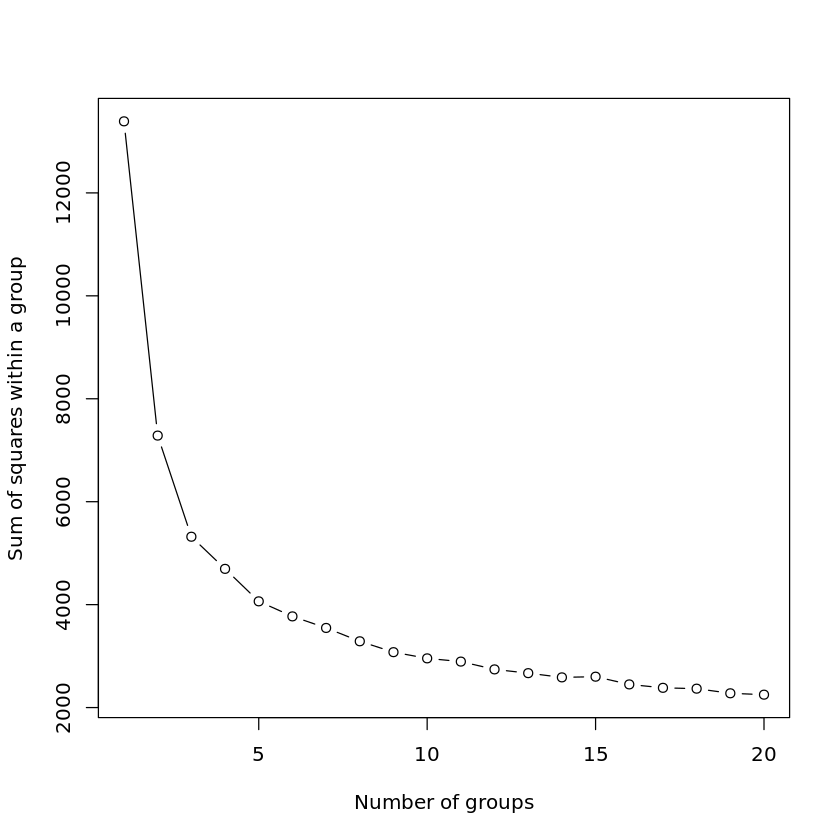

In [37]:
wssplot(nba.transformado[, -11], nc = 20)

Gap statistic tampoco no ayuda demasiado a encontrar el K óptimo. En el gráfico de arriba vemos que tampoco se produce ningún cambio brusco de pendiente que nos indique algún número óptimo de clusters. Vamos a aplicar el método de kmeans con el k=2 que es el que tiene sentido y analizaremos los resultados.

In [36]:
kmeans.nba <- kmeans(prcomp(scale(nba.transformado[-11]))$x, centers=2, nstart=25)
check.cluster(kmeans.nba, nba.transformado$TARGET_5Yrs)

Direct agreement: 0 of 2 pairs
Iterations for permutation matching: 2 
Cases in matched pairs: 58.13 %
        
original   1   2
       0 445  64
       1 497 334
        
original   1   2
       0 445  64
       1 497 334


Vemos que usar un k=2 no nos da una buena división, es posible que este dataset no tenga una división tan clara de los datos como sospechábamos al analizar los resultados de Gap Statistic y Estabilidad.

## Ejercicio 4

Vamos a aplicar dos modelos de clasificación: Naive Bayes y KNN.

### Naive bayes

In [52]:
## Dividimos el dataset en conjuntos de test y train
sample <- sample.int(n = nrow(nba.transformado), size = floor(.8*nrow(nba.transformado)), replace = F)
nba.transformado.train <- nba.transformado[sample, ]
nba.transformado.test  <- nba.transformado[-sample, ]


In [56]:
nba.naive <- naiveBayes(TARGET_5Yrs~., data=nba.transformado.train) 
# Predicting on test data'
y_pred <- predict(nba.naive, newdata = nba.transformado.test)
# Confusion Matrix
cm <- table(nba.transformado.test$TARGET_5Yrs, y_pred)
# Model Evaluation
confusionMatrix(cm)

 

Confusion Matrix and Statistics

   y_pred
     0  1
  0 81 21
  1 79 87
                                          
               Accuracy : 0.6269          
                 95% CI : (0.5659, 0.6849)
    No Information Rate : 0.597           
    P-Value [Acc > NIR] : 0.1753          
                                          
                  Kappa : 0.2868          
                                          
 Mcnemar's Test P-Value : 1.198e-08       
                                          
            Sensitivity : 0.5062          
            Specificity : 0.8056          
         Pos Pred Value : 0.7941          
         Neg Pred Value : 0.5241          
             Prevalence : 0.5970          
         Detection Rate : 0.3022          
   Detection Prevalence : 0.3806          
      Balanced Accuracy : 0.6559          
                                          
       'Positive' Class : 0               
                                          

Con Bayes logramos una accuracy del 62% aproximadamente, no es tan bueno el valor, vamos a ver si otro modelo de clasificación mejora este resultado así vemos cual resuelve mejor el problema que plantea el dataset.

### KNN

Aplicamos el método de k-nearest neighbors optimizando el parámetro k.

In [64]:
library(class)

In [85]:
best.k <- 5
ks = c(5:40)
acs = c()
for(k in 5:40){
    knn <- knn(train=nba.transformado.train, test=nba.transformado.test, cl=nba.transformado.train[, 11], k=k)
    acc <- 100 * sum(nba.transformado.test[, 11] == knn)/NROW(nba.transformado.test[, 11])
    acs <- c(acs, acc)
    if(acc == max(acs)){
        best.k <- k
    }
}
cat("Best k: ", best.k)


Best k:  12

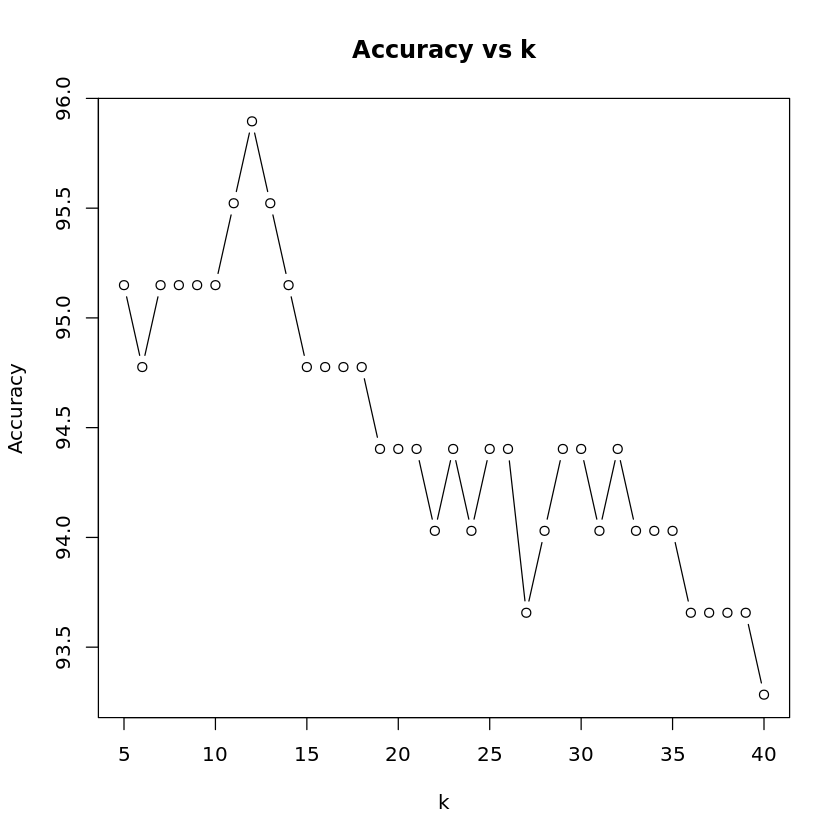

In [86]:
## Graficamos la accuracy en función de k
plot(ks, acs, type="b", xlab="k", ylab="Accuracy", main="Accuracy vs k")

A lo largo de varias corridas vemos que el valor óptimo de K varía entre 10 y 15 ya para valores más grandes el error asciende asi que no tiene sentido extendernos más. Vamos a probar con 12 y medir la accuracy.

In [84]:
knn <- knn(train=nba.transformado.train, test=nba.transformado.test, cl=nba.transformado.train[, 11], k=12)
100 * sum(nba.transformado.test[, 11] == knn)/NROW(nba.transformado.test[, 11])

[1] 95.89552

Notar que logramos una accuracy del 95% aproximadamente, optimizando el valor de K. Este método de aprendizaje se adapta muy bien a este tipo de problema.